# Fuzzy Augmentation

In [1]:
import sys
sys.path.append('C:\\git\\reject-inference-toy-examples\\')
from reject_inference.utils.helpers import CreditMetrics
from reject_inference.main import RejectInference

import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns

In [2]:
df = pd.read_csv("../data/credit_data.csv").dropna().drop_duplicates()

## Modelagem com aprovados

In [3]:
# Step 0: Dividir amostra entre aprovados e rejeitados para a simulação
X_aprovados, X_rejeitados, y_aprovados, y_rejeitados = train_test_split(
    df.drop(columns=['default', 'clientid']), df['default'], test_size=0.3, random_state=42
)

In [4]:
# Step 1: Construir modelo na população conhecida (KGB)
scorecard_A = LogisticRegression()
scorecard_A.fit(X_aprovados, y_aprovados)

LogisticRegression()

## Inferência de rejeitados

In [5]:
# Step 2: Estimar probabilidades de cada rejeitado ser bom/mau usando o 'known good/bad model' (scorecard A) 
reject_scores  = scorecard_A.predict_proba(X_rejeitados)[:, 0]

X_rejeitados['p_good'] = 1 - reject_scores
X_rejeitados['p_bad'] = reject_scores

In [6]:
# Step 3: Gerar performance dos rejeitados usando fuzzy augmentation
infer = RejectInference(data= X_rejeitados,
                        bad_prob_column='p_bad',
                        target_column_future_name='default',
                        application_vars=['loan', 'income', 'age'])

# Nesse caso a probabilidade de aprovação está sendo passada como um valor qualquer,
# mas o ideal é construir um modelo AR (aprovados/rejeitados) para passar nesse argumento
# approval_prob um numpy.ndarray com a probabilidade de aprovação resultante desse modelo.
# Por fim teremos a combinação da probabilidade de ser mau com a probabilidade de aprovação:
rejeitados_inferidos = infer.fuzzy_augmentation(approval_prob=0.8)

Sucesso: Dataset com formato esperado: Variáveis do KGB Model + Probas 1/0


In [8]:
pd.crosstab(y_rejeitados,
            rejeitados_inferidos.default,
            normalize=False)

default,0,1
default,,
0,164,127
1,29,31


## Modelagem com aprovados e reprovados

In [9]:
# Une os dados
aprovados = pd.concat([X_aprovados[['income', 'age', 'loan']], y_aprovados], axis=1)
aprovados['weight'] = 1

rejeitados = rejeitados_inferidos[['income', 'age', 'loan', 'default', 'weight']].copy()

aprovados['ref'] = 'kgb'
rejeitados['ref'] = 'infer'

df_final = pd.concat([aprovados, rejeitados], axis=0)

In [10]:
# Step 4: Modelar com KGB + inferidos
# Step 4.1: Divisão treino/teste

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df_final[['income', 'age', 'loan']],
    df_final['default'],
    df_final['weight'],
    test_size=0.2, random_state=42
)

In [11]:
scorecard_B = LogisticRegression()
scorecard_B.fit(X_train, y_train, sample_weight=weights_train)

LogisticRegression()

## Resultados do Modelo

In [12]:
y_pred = scorecard_B.predict(X_test)

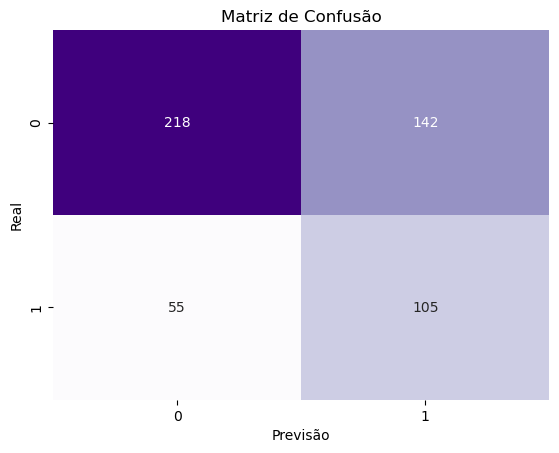

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.61      0.69       360
           1       0.43      0.66      0.52       160

    accuracy                           0.62       520
   macro avg       0.61      0.63      0.60       520
weighted avg       0.68      0.62      0.64       520



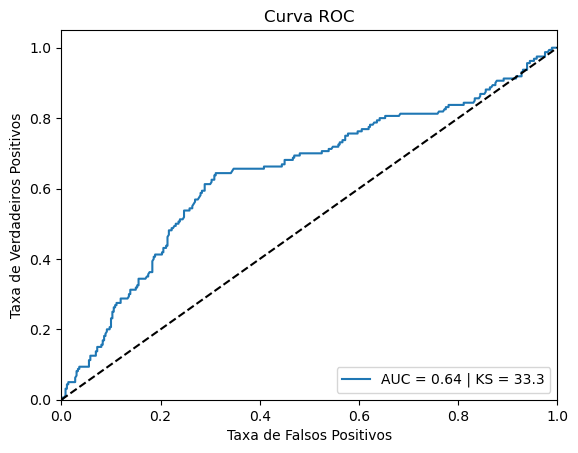

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, scorecard_B.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, scorecard_B.predict_proba(X_test)[:, 1])
ks = np.max(np.abs(tpr - fpr))

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f} | KS = {100*ks:.1f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

plt.show()

### Métricas de crédito para comparação das técnicas

In [16]:
metricas = CreditMetrics(data = df_final,
                         target_column = 'default',
                        inference_reference_column = 'ref')

metricas.generate_report(y_train, 
                        scorecard_B.predict(X_train),
                        y_test,
                        scorecard_B.predict(X_test),)

,Overall Bad Rate,Known GB Odds/Inferred GB Odds,Gini Dev,Gini Test,Overfitting (gini_dev - gini_test)
0,30.14,6.64,18.11,26.18,-8.07
